<a href="https://colab.research.google.com/github/AOdrio/Datathon/blob/main/cuarto%3F-usando%20logaritmo%20y%20eso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [228]:
import pandas as pd
import numpy as np

import xgboost as xgb
from matplotlib import pyplot as plt
#import seaborn as sns 

from sklearn.model_selection import train_test_split
#from sklearn.metrics import mean_absolute_error
#from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error as MAPE
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.linear_model import LinearRegression as LR
#from sklearn.neighbors import KNeighborsRegressor as KNN

SEED = 42

In [256]:
url='https://drive.google.com/file/d/1KH1fB83JDAWcMRCHKFf9SmcGH7MQkupE/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df_original = pd.read_csv(url)

In [ ]:
df_original.describe()

In [257]:
y = df_original.pop("ingreso")
X = df_original.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [250]:
print('Todo: ',df_original.shape)
print('Train:',X_train.shape)
print('Test: ',X_test.shape)

Todo:  (40000, 24)
Train: (32000, 24)
Test:  (8000, 24)


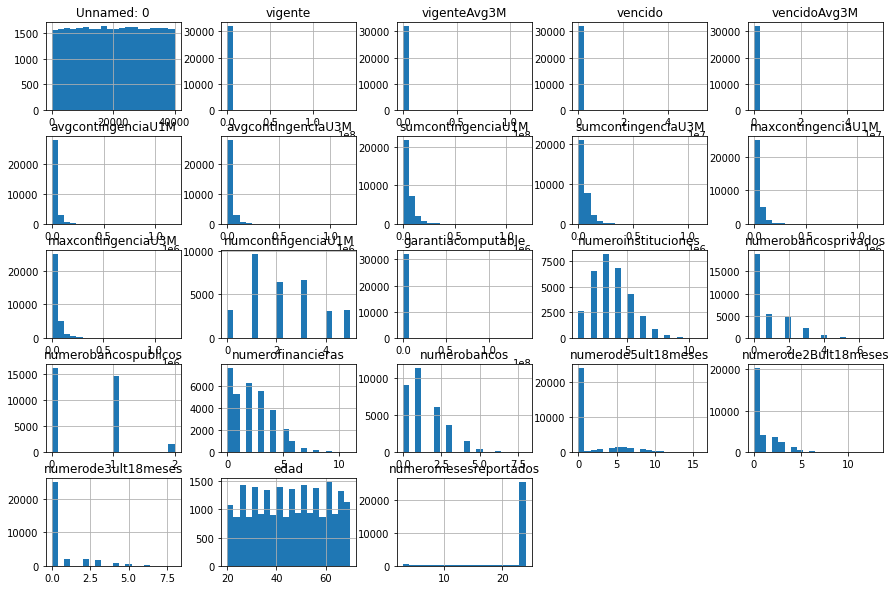

In [213]:
ax = X_train.hist(bins=20, figsize=(15, 10))

In [258]:
def transfromar_DataFrame (df,edad_media, columns):
  df = df.copy()
  df = df.drop(df.columns[0],axis=1)
  #Remplazar nulls de la edad con la media de la columna
  df['edad'] = df['edad'].fillna(edad_media, inplace=False)

  #Transformar categóricas en numéricas
  df['peorcalificacionBCU'] = (df['peorcalificacionBCU'].
                              str.replace('5','6').
                              str.replace('4','5').
                              str.replace('3','4').
                              str.replace('2B','3').
                              str.replace('2A','2').
                              str.replace('1C','1').
                              str.replace('1A','0'))
  df['peorcalificacionBCU'] = pd.to_numeric(df['peorcalificacionBCU'], downcast='integer')
  for column in columns:
    df[column].replace(0,1,inplace=True)
    df[column] = np.log(df[column])
    #df[column] = np.cbrt(df[column])
    
  return df

In [259]:
edad_media = X_train['edad'].mean()
columns =['vigente', 'vigenteAvg3M', 'vencido','vencidoAvg3M','avgcontingenciaU1M','avgcontingenciaU3M','sumcontingenciaU1M','sumcontingenciaU3M','maxcontingenciaU1M','maxcontingenciaU3M','garantiacomputable'] 

In [260]:
X_train = transfromar_DataFrame(X_train,edad_media,columns)
X_test = transfromar_DataFrame(X_test,edad_media,columns)

In [261]:
y_train = np.log(y_train)
#y_test = np.cbrt(y_test)

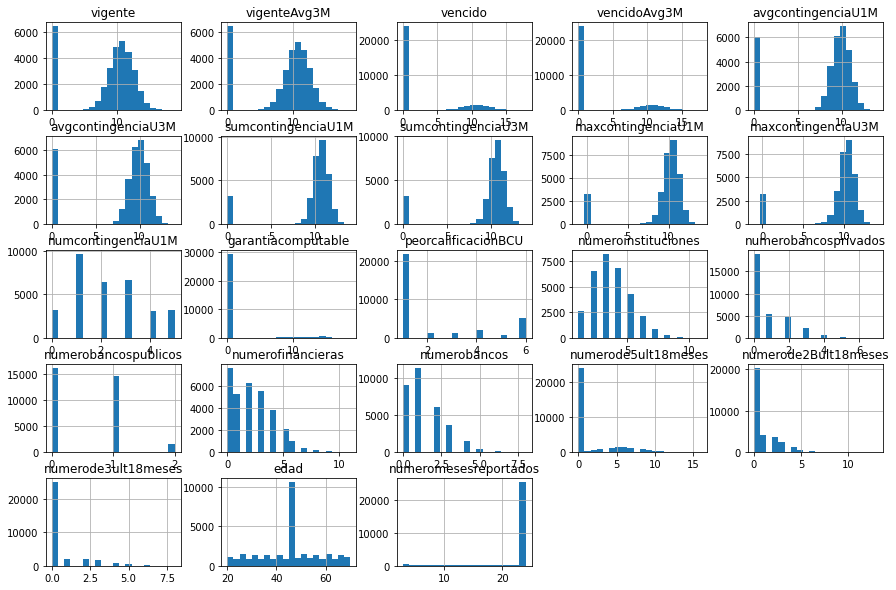

In [262]:
ax = X_train .hist(bins=20, figsize=(15, 10))

In [263]:
# La linea base es el mediana de los ingresos
baseline_preds = pd.DataFrame(y_train.copy())
mediana = y_train.median()
baseline_preds['mediana'] = mediana

baseline_MAPE = MAPE(y_train,baseline_preds['mediana'])
print('MAPE linea base: ', round(baseline_MAPE *100, 2))
print('Mediana de ingreso: ', round(mediana))

MAPE linea base:  3.95
Mediana de ingreso:  11


In [264]:
model_xgb = xgb.XGBRegressor(
            objective = "reg:squarederror",
            eval_metric = "mae",
            #tree_method = "gpu_hist",
            booster = "gbtree",
            random_state = SEED,
            n_estimators = 1000,
            learning_rate = 0.01,
            max_depth = 11,
            min_child_weight = 7,
            subsample = 0.9,
            colsample_bytree = 1,
            colsample_bynode = 0.7,
            colsample_bylevel = 0.8,
            verbosity = 0,
            n_jobs = -1,
            )

In [275]:
model_xgb.fit(X_train,y_train)
preds_xgb = model_xgb.predict(X_test)

In [276]:
#preds_xgb = np.exp(preds_xgb)
MAPE_xgb = MAPE(y_test, preds_xgb)
print('MAPE_xgb:', round(100*MAPE_xgb, 2))

MAPE_xgb: 99.98


Text(0.5, 0, 'Xgboost Feature Importance')

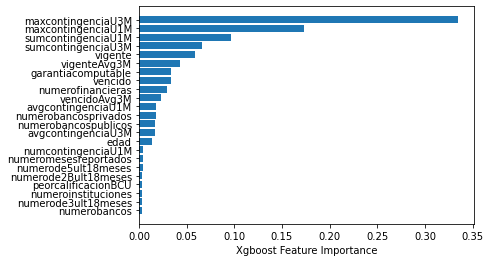

In [267]:
sorted_idx = model_xgb.feature_importances_.argsort()
plt.barh(list(X_train.columns[sorted_idx]), model_xgb.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

In [268]:
#data de test
url='https://drive.google.com/file/d/1sMkorQLOmf2cNGRwXkQLKeciGSUpL_ez/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df_test_original = pd.read_csv(url)

In [269]:
df_test = transfromar_DataFrame(df_test_original,edad_media,columns)


In [272]:
preds_datathon = model_xgb.predict(df_test)
preds_datathon  = np.exp(preds_datathon)

In [273]:
pd.DataFrame(preds_datathon).to_csv('predicciones4.csv') 